
# About this notebook

This notebook walks through a small but complete multi agent writing workflow that plans, researches, and drafts a developer focused blog post. It combines structured outputs, a tool using research step, and a simple LangGraph pipeline with checkpoints.

## What it shows

* **A four stage graph**

  1. **propose** generates three creative options with structured output
  2. **reflect** critiques and selects the best option with a stronger judge
  3. **research** uses SerpAPI search to collect sources and synthesize JSON
  4. **draft** produces a final outline and intro for the chosen plan
* **Separation of roles and models**

  * a small creative generator
  * a stricter judge
  * a tool bound researcher
  * a small writer for the final draft
* **Typed state** with accumulated messages, option and choice JSON, synthesized sources, and the final draft
* **In memory checkpoints** with `MemorySaver`
* **Readable streaming trace** that prints per node updates during execution
* **Graph preview** via Mermaid PNG

## What you will run

1. Load `OPENAI_API_KEY` and `SERPAPI_API_KEY` from `.env`.
2. Define an `internet_search` tool that returns compact JSON results from SerpAPI.
3. Create Pydantic schemas for options, choice, and queries to keep outputs structured.
4. Wire a **linear LangGraph** with four nodes and compile it with a checkpointer.
5. Start a run with a topic prompt and watch the system stream updates from each node.
6. Inspect the final draft and render the graph image.

## How it works

* **Propose options** uses `with_structured_output(OptionsPayload)` to force three options with consistent fields.
* **Reflect and select** uses a stronger model with `ChoicePayload` to pick the best option by index with a rationale. The code clamps the index defensively.
* **Research with tools**

  * the researcher proposes 3 to 5 precise queries with a structured schema
  * the notebook calls `internet_search` for each query and collects raw findings
  * a compact synthesis step turns findings into a clean `sources_json` payload with suggested citations
* **Draft outline and intro** converts the chosen plan and sources into a title, audience sentence, a five section outline, and a short intro.

## Why this pattern

* Clear role separation improves quality and transparency. Generation, evaluation, research, and writing are handled by different prompts and sometimes different models.
* Structured outputs reduce ambiguity and make routing trivial.
* Tool use is explicit and observable which makes the process auditable.
* LangGraph keeps control flow readable and provides thread scoped memory with almost no boilerplate.

## Extend and adapt

* Swap SerpAPI with your preferred search or add a docs repository tool.
* Add a factuality checker or citation verifier between research and drafting.
* Persist checkpoints to a database for long running projects.
* Add a final formatter node that turns the draft into Markdown or HTML.

## Requirements and notes

* `OPENAI_API_KEY` is required. Live search needs `SERPAPI_API_KEY`.
* Internet results change over time. Expect different sources on different runs.
* The creative model is set slightly higher temperature. The judge is near zero for stability.
* Token and API costs can add up when streaming multiple stages.

## Intended audience

Engineers, technical writers, and researchers who want a practical template for a small, role based writing agent that mixes structured planning, tool assisted research, and drafting inside a simple LangGraph workflow.


# Open in Colab
<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/ai-agents-the-definitive-guide/blob/main/CH02/ch02_ToT.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Dependencies

In [ ]:
!pip install -q langchain==0.3.27 \
                langgraph==0.6.7 \
                langchain-openai==0.3.32 \
                langchain_experimental==0.3.4 \
                langchain_community==0.3.29 \
                python-dotenv==1.0.1 \
                langchain-core==0.3.75 \
                serpapi==0.1.5 \
                google-search-results==2.4.2

# API Setup

In [ ]:
# --- API Key Setup ---
# Option 1 (preferred): create a `.env` file in your project folder with:
# OPENAI_API_KEY=your_openai_key_here
# SERPAPI_API_KEY=your_serpapi_key_here
#
# Option 2: set it directly in the notebook with magic:
# %env OPENAI_API_KEY=your_openai_key_here
# %env SERPAPI_API_KEY=your_serpapi_key_here

from dotenv import load_dotenv
import os

# Load from .env if available
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
serp_api_key = os.getenv("SERPAPI_API_KEY")

# Fallback: ask if still missing
if not OPENAI_API_KEY:
    print("⚠️ OPENAI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    OPENAI_API_KEY = input("Enter your OPENAI_API_KEY: ").strip()

if not serp_api_key:
    print("⚠️ SERPAPI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    serp_api_key = input("Enter your SERPAPI_API_KEY: ").strip()

print("✅ API keys loaded successfully!")



# Imports

In [ ]:
import os, json, uuid
from typing import Annotated, List, TypedDict

from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage
from langchain_core.tools import tool
from serpapi import GoogleSearch

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# Tool: internet_search

In [ ]:
@tool("internet_search")
def internet_search(query: str) -> str:
    """Search Google via SerpAPI for up to date information. Returns compact JSON."""
    key = os.getenv("SERPAPI_API_KEY")
    if not key:
        return "[]"
    params = {"engine": "google", "q": query, "api_key": key, "num": 5, "hl": "en", "gl": "us"}
    data = GoogleSearch(params).get_dict()
    out = []
    for r in (data.get("organic_results") or [])[:5]:
        out.append({
            "title": r.get("title"),
            "link": r.get("link"),
            "snippet": r.get("snippet"),
            "source": r.get("source"),
        })
    return json.dumps(out, ensure_ascii=False)

tools = [internet_search]

# Models: small generator, stronger judge, tool-bound researcher

In [ ]:
gen_llm       = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)   # creative, cheaper
judge_llm     = ChatOpenAI(model="gpt-4o",      temperature=0.2)   # stricter judge
research_llm  = ChatOpenAI(model="gpt-4o-mini", temperature=0.2).bind_tools(tools, tool_choice="auto")
writer_llm    = gen_llm  # reuse small model for drafting


# Structured payloads (Pydantic v2)

In [ ]:
class Option(BaseModel):
    title: str
    audience: str
    angle: str
    outline: List[str] = Field(min_items=5, max_items=5)
    rationale: str

class OptionsPayload(BaseModel):
    options: List[Option] = Field(min_items=3, max_items=3)

class ChoicePayload(BaseModel):
    choice_index: int = Field(ge=0, le=2)
    rationale: str

class Queries(BaseModel):
    queries: List[str] = Field(min_items=3, max_items=5)


# State

In [ ]:
class BlogState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    topic: str
    options_json: str | None
    choice_json: str | None
    sources_json: str | None
    draft: str | None

# Nodes

In [ ]:

def propose_options(state: BlogState) -> BlogState:
    """Generator (small): propose 3 creative approaches (ToT-style branching)."""
    proposer = gen_llm.with_structured_output(OptionsPayload)
    prompt = (
        "Generate exactly 3 distinct approaches for a developer-focused blog on:\n"
        f"{state['topic']}\n\nFor each option, provide: title, audience, angle, "
        "a 5-bullet outline, and a concise rationale."
    )
    payload: OptionsPayload = proposer.invoke(prompt)
    state["options_json"] = payload.model_dump_json()
    state["messages"].append(AIMessage(content=state["options_json"]))
    return state

def reflect_and_select(state: BlogState) -> BlogState:
    """Judge (stronger): critique options and select best one."""
    chooser = judge_llm.with_structured_output(ChoicePayload)
    eval_prompt = (
        "Evaluate the 3 approaches for clarity, originality, developer relevance, "
        "and feasibility under time constraints. Pick ONE by index 0..2 and justify.\n\n"
        f"Options JSON:\n{state['options_json']}"
    )
    choice: ChoicePayload = chooser.invoke(eval_prompt)
    # Defensive clamp
    opts = json.loads(state["options_json"])["options"]
    idx = max(0, min(choice.choice_index, len(opts)-1))
    choice.choice_index = idx
    state["choice_json"] = choice.model_dump_json()
    state["messages"].append(AIMessage(content=state["choice_json"]))
    return state

def research_with_tools(state: BlogState) -> BlogState:
    """Researcher (tool-using): propose queries, call search tool(s), synthesize sources JSON."""
    # 1) Ask for tight queries (structured)
    q_llm = research_llm.with_structured_output(Queries)
    q_payload: Queries = q_llm.invoke(
        "Propose 3–5 precise web queries (docs/repos/papers/blog posts) to support the chosen approach.\n"
        f"Topic: {state['topic']}\nOptions: {state['options_json']}\nChoice: {state['choice_json']}"
    )

    # 2) Call tool(s) explicitly (deterministic, observable)
    findings = []
    for q in q_payload.queries:
        res = internet_search.invoke({"query": q})
        try:
            findings.append({"query": q, "results": json.loads(res)})
        except Exception:
            findings.append({"query": q, "results": []})

    # 3) Synthesize to a clean JSON list of sources
    synth_prompt = (
        "From these search findings, produce JSON list 'sources': "
        "[{query, top_findings: [3-5 bullets], suggested_citations: [{title, url}]}]. "
        "Return JSON only."
    )
    synth = research_llm.invoke([
        ("system", "Return JSON only."),
        HumanMessage(content=json.dumps(findings, ensure_ascii=False))
    ])
    state["sources_json"] = synth.content
    state["messages"].append(AIMessage(content=state["sources_json"]))
    return state

def draft_outline_and_intro(state: BlogState) -> BlogState:
    """Writer (small): outline + intro from chosen plan and sources."""
    system = (
        "You are a senior technical writer. Using the chosen approach and sources, produce:\n"
        "1) Final title\n2) Audience sentence\n3) 5-section outline (2–3 bullets each)\n"
        "4) 150–200 word intro. Be clear, concrete, and avoid hype."
    )
    ai = writer_llm.invoke([
        ("system", system),
        HumanMessage(content=f"Choice:\n{state['choice_json']}\n\nSources:\n{state['sources_json']}")
    ])
    state["draft"] = ai.content
    state["messages"].append(ai)
    return state

# Graph wiring

In [ ]:
graph = StateGraph(BlogState)
graph.add_node("propose", propose_options)        # small creative generator
graph.add_node("reflect", reflect_and_select)     # stronger judge/reflector
graph.add_node("research", research_with_tools)   # tool-using researcher
graph.add_node("draft", draft_outline_and_intro)  # small writer

graph.add_edge(START, "propose")
graph.add_edge("propose", "reflect")
graph.add_edge("reflect", "research")
graph.add_edge("research", "draft")
graph.add_edge("draft", END)

checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

# Run

In [ ]:
cfg = {"configurable": {"thread_id": f"blog-{uuid.uuid4()}"}, "recursion_limit": 40}
initial: BlogState = {
    "messages": [HumanMessage(content="Plan a blog post about AI agents for developers.")],
    "topic": "AI Agents for Developers: From LLMs to Tool-Using Systems",
    "options_json": None,
    "choice_json": None,
    "sources_json": None,
    "draft": None,
}

for update in app.stream(initial, config=cfg, stream_mode="updates"):
    for node, payload in update.items():
        print(f"\n[enter {node}] keys: {list(payload.keys())}")
        if "messages" in payload and payload["messages"]:
            m = payload["messages"][-1]
            text = getattr(m, "content", "")
            print((text if isinstance(text, str) else str(text))[:400], "...")

final = app.get_state(cfg).values
print("\n===== FINAL DRAFT =====\n")
print((final.get("draft") or ""))



[enter propose] keys: ['messages', 'topic', 'options_json', 'choice_json', 'sources_json', 'draft']
{"options":[{"title":"Unlocking AI Agents: A Developer's Guide to LLMs and Beyond","audience":"Software Developers and AI Enthusiasts","angle":"Practical implementation of AI agents using LLMs and other tools.","outline":["Introduction to AI Agents and Their Importance","Overview of Large Language Models (LLMs) and Their Capabilities","Step-by-Step Guide to Implementing an LLM in Your Project","Ex ...

[enter reflect] keys: ['messages', 'topic', 'options_json', 'choice_json', 'sources_json', 'draft']
{"choice_index":0,"rationale":"**Choice Index: 0**\n\n**Title:** Unlocking AI Agents: A Developer's Guide to LLMs and Beyond\n\n**Justification:**\n\n1. **Clarity:**\n   - The title and outline clearly communicate the focus on practical implementation, which is essential for developers who are eager to apply AI technologies in real-world projects.\n   - The step-by-step guide format ensures

# Display the graph

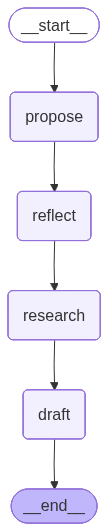

In [ ]:

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))